In [14]:
#Import 
import warnings; warnings.simplefilter('ignore') #for PCoA warnings
import pandas as pd
import numpy as np
import random
from scipy import stats
import itertools
#import data
from biom import load_table
from gneiss.util import match
#plotting
import seaborn as sns
import matplotlib.pyplot as plt
#MOCK data generation
from gneiss import util
#biplots
from sklearn.datasets import samples_generator as sg
from sklearn.cluster.bicluster import SpectralBiclustering
#from sklearn.metrics import consensus_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
#completions
from DEICODE.untangle import complete_matrix,machine_learning,biplot
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute,IterativeSVD,MICE,MatrixFactorization
#transforms 
from skbio.stats.composition import clr,ilr
#PCoA
from skbio import DistanceMatrix
from skbio.stats.ordination import pcoa
from scipy.spatial.distance import pdist, squareform
from skbio.stats import subsample_counts
#blocks
from gneiss.util import band_diagonal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson, multivariate_normal
from skbio.stats.composition import clr
# Intials
rand = np.random.RandomState(42)
fnts=12
# make it look nice
sns.set(font="monospace")
import warnings
warnings.filterwarnings("ignore")
from IPython.core.display import HTML
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-white')
plt.style.use('seaborn-darkgrid')
plt.style.use('seaborn-paper')
HTML("""<style>div.cell { /* Tunes the space between cells */margin-top:1em;margin-bottom:1em;}div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 3em;line-height:1.4em;text-align:center;}
div.text_cell_render h2 { /*  Parts names nearer from text */margin-bottom: -0.4em;}
div.text_cell_render { /* Customize text cells */font-family: 'Times New Roman';font-size:1.2em;line-height:1.4em;
padding-left:3em;padding-right:3em;}</style>""")
%matplotlib inline

In [19]:
def block_diagonal_gaus(ncols, nrows, nblocks,minval=0,maxval=1.0):
    """ Generate block diagonal with uniformly distributed values within blocks.
    Parameters
    ----------
    ncol : int
        Number of columns
    nrows : int
        Number of rows
    nblocks : int
        Number of blocks
    Returns
    -------
    np.array
        Table with a block diagonal where the rows represent samples
        and the columns represent features.  The values within the blocks
        are uniformly distributed between 0 and 1.
    Note
    ----
    The number of blocks specified by `nblocks` needs to be greater than 1.
    """
        
    
    if nblocks <= 1:
        raise ValueError('`nblocks` needs to be greater than 1.')
    mat = np.zeros((nrows, ncols))
    
    
    rank = 2**3 - 1
    gradient = np.linspace(0, 10, nrows)
    mu = np.linspace(0, 10, ncols)
    sigma = 1
    xs = [norm.pdf(gradient, loc=mu[i], scale=sigma)
          for i in range(len(mu))]
    mat = np.vstack(xs).T
    
    
    print()
    block_cols = ncols // nblocks
    block_rows = nrows // nblocks
    for b in range(nblocks-1):
        
        gradient = np.linspace(5, 5, block_rows)
        mu = np.linspace(0, 10, block_cols)
        sigma = 4
        xs = [norm.pdf(gradient, loc=mu[i], scale=sigma)
              for i in range(len(mu))]
        B = np.vstack(xs).T*maxval
                
        #B = np.random.uniform(minval,maxval,size=(block_rows, block_cols))
        lower_row = block_rows * b
        upper_row = min(block_rows*(b+1), nrows)
        lower_col = block_cols * b
        upper_col = min(block_cols*(b+1), ncols)

        mat[lower_row:upper_row, lower_col:upper_col] = B

    # Make last block fill in the remainder
    gradient = np.linspace(5, 5, nrows-upper_row)
    mu = np.linspace(0, 10, ncols-upper_col)
    sigma = 4
    xs = [norm.pdf(gradient, loc=mu[i], scale=sigma)
          for i in range(len(mu))]
    B = np.vstack(xs).T*maxval
    
    
    mat[upper_row:, upper_col:] = B
    return mat

def plot_pcoa(otupcoadfs,mapping,catvis,fig_fontsize=12,suptit_=None,method='braycurtis'):
    
    if len(otupcoadfs)==1:
        fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(8, 8)) 
        otupcoadf=otupcoadfs[0]
        title='Mean Sequences Per Sample:'+str(np.mean(otupcoadf.sum())).split('.')[0]
        pcaplot=pcoa(DistanceMatrix(pdist(otupcoadf.as_matrix().T,method),list(otupcoadf.columns))).samples[['PC1','PC2','PC3']]
        pcaplot[catvis]=list(mapping.T[catvis])
        for ((key, grp)) in pcaplot.groupby(catvis):
            ax1.scatter(grp['PC1'], grp['PC2'], color=next(ax1._get_lines.prop_cycler)['color'], label=key, s=50)
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.legend(loc=2,prop={'size':16},bbox_to_anchor=(1.0, 1.0))
        ax1.set_title(title,fontsize=fig_fontsize,y=1.05)
        ax1.set_ylabel('$PC-1$',fontsize=fig_fontsize-2)
        ax1.set_xlabel('$PC-2$',fontsize=fig_fontsize-2) 
        if suptit_!=None:
            plt.suptitle(suptit_,y=1.05,fontsize=fig_fontsize+8)
        return fig
        
    else:
        fig, axn = plt.subplots(ncols=len(otupcoadfs), nrows=1, figsize=(15, 5)) 

        for ax1,(count_,otupcoadf) in zip(axn.flat,enumerate(otupcoadfs)):
            title=str(np.mean(otupcoadf.sum())).split('.')[0]+' Sequences Per Sample'
            pcaplot=pcoa(DistanceMatrix(pdist(otupcoadf.as_matrix().T,method),list(otupcoadf.columns))).samples[['PC1','PC2','PC3']]
            pcaplot[catvis]=list(mapping.T[catvis])
            for ((key, grp)) in pcaplot.groupby(catvis):
                ax1.scatter(grp['PC1'], grp['PC2'], color=next(ax1._get_lines.prop_cycler)['color'], label=key, s=50)
            ax1.set_xticks([])
            ax1.set_yticks([])
            if count_==len(otupcoadfs)-1:
                ax1.legend(loc=2,prop={'size':16},bbox_to_anchor=(1.0, 1.0))
            ax1.set_title(title,fontsize=fig_fontsize,y=1.05)
            ax1.set_ylabel('$PC-1$',fontsize=fig_fontsize-2)
            ax1.set_xlabel('$PC-2$',fontsize=fig_fontsize-2) 
        if suptit_!=None:
            plt.suptitle(suptit_,y=1.05,fontsize=fig_fontsize+8)
        return fig
    
def add_noise(X_true,hoced=None,hsced=None,inten=None,spar=None):
    
    '''
    This function, induces sparcity and then can add Heteroscedastic or Homoscedastic noise at desried levels.
    
    
    hoced, float [0,1]
    The percentage of homoscedastic noise 
    
    hsced, float [0,1]
    The percentage of Heteroscedastic noise 
    
    inten, float
    The max value of the noise   
    
    spar, float
    The percentage of density desired, min is zero but no max
    
    '''
    X_noise=X_true.copy()
    
    # Induce low-density into the matrix
    if spar is not None:
        X_noise=np.array(X_noise)
        mask = np.random.randint(0,spar,size=X_noise.shape).astype(np.bool)
        rand_zeros = np.random.rand(*X_noise.shape)*0
        X_noise[mask] = rand_zeros[mask]
    
    
    # add Homoscedastic noise
    if hoced is not None:
        err = hoced * np.ones_like(X_noise.copy())
        X_noise = rand.normal(X_noise.copy(), err)
    
    # add Heteroscedastic noise
    if hsced is not None:
        err = hsced * np.ones_like(X_noise)
        i = rand.randint(0, err.shape[0], 5000)
        j = rand.randint(0, err.shape[1], 5000)
        err[i, j] = inten
        X_noise = abs(rand.normal(X_noise, err))


    #return the noisy data 
    return pd.DataFrame(X_noise,columns=X_true.columns,index=X_true.index)   

def mean_KL(a,b):

    kl = []
    for i in a.index:

        kl += [stats.entropy(a.loc[i].values,
                             b.loc[i].values)]
            
    #return np.mean(kl)
    return kl

# Keyboard real low rank data example

In [3]:
# import observation data
in_biom='data/benchmarking/keyboard.biom' #import biom file
table = load_table(in_biom)
read_filter = lambda val, id_, md: sum(val) > 0
table.filter(read_filter, axis='sample')
table.filter(read_filter, axis='observation')
otutabledf=table.to_dataframe()
otutabledf=otutabledf.T
otutabledf.drop_duplicates(inplace=True)

# Get OTU to taxa match
taxonomy=table.metadata_to_dataframe('observation')
taxonomy.columns=['kingdom', 'phylum', 'class', 'order', 
                             'family', 'genus', 'species']
taxonomy['taxonomy'] = taxonomy[taxonomy.columns].apply(lambda x: ';'.join(x), axis=1)

#mapping import 
map_file='data/benchmarking/keyboard.txt' #import metadata
mappingdf= pd.read_table('%s'%map_file, index_col=0,low_memory=False)
mappingdf=mappingdf.replace(np.nan,'Unknown', regex=True)
mappingdf.index=list(map(str,mappingdf.index))
mappingdf=mappingdf.astype(str)
mappingdf=mappingdf[~mappingdf.index.duplicated(keep='first')]

#match the tables
otutabledf,mappingdf=match(otutabledf,mappingdf[mappingdf['host_subject_id'].isin(['M2','M3','M9'])])

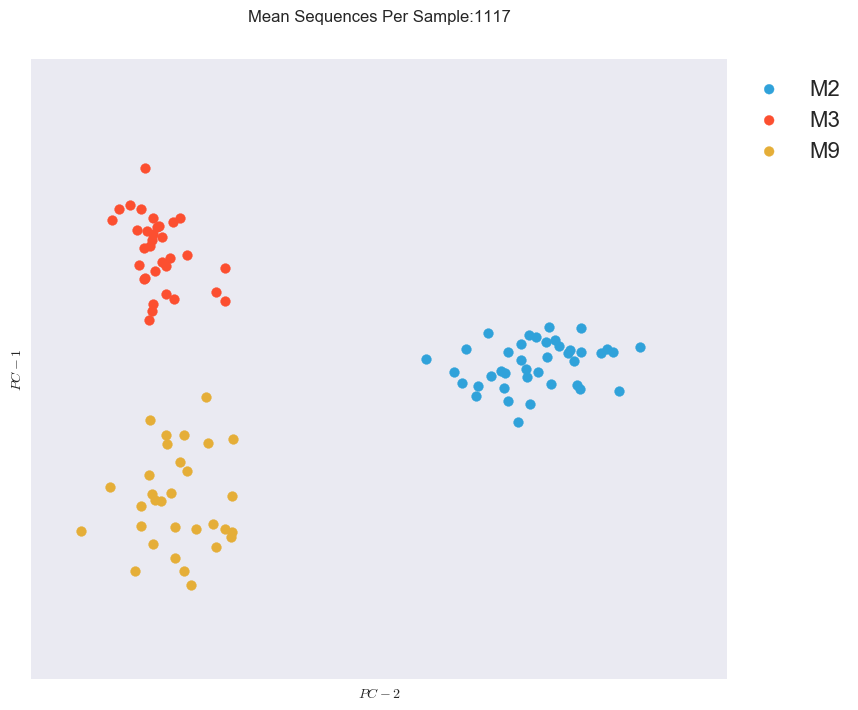

In [4]:
#plot data 
fig=plot_pcoa([otutabledf.T],mappingdf.T,'host_subject_id',method='jaccard')
plt.show()

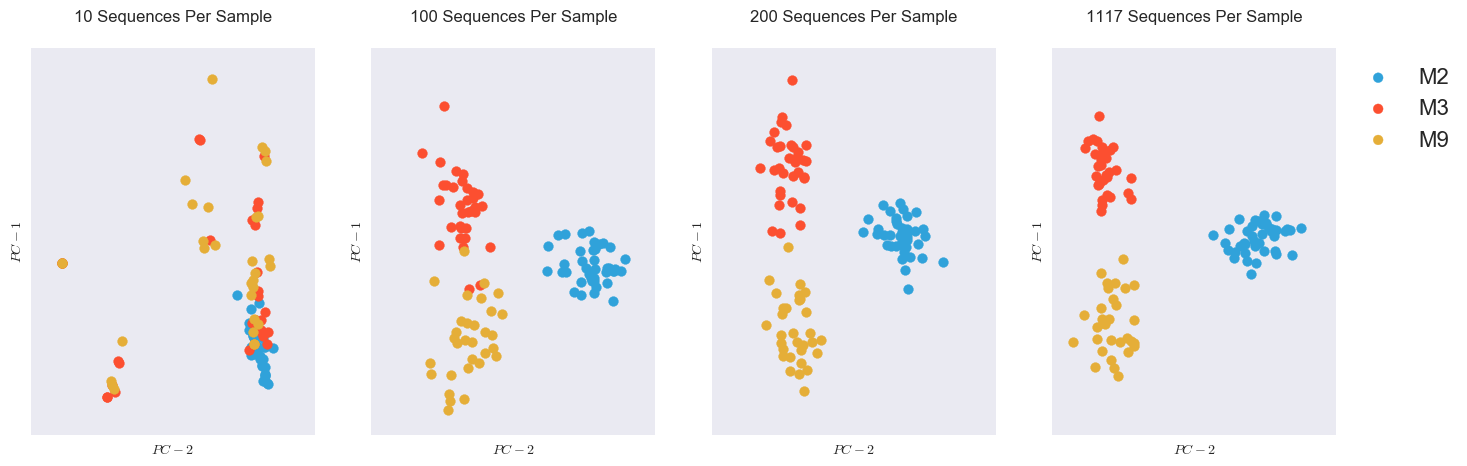

In [5]:
# sub sample 
Subsamples_noisy=[]
for sub_ in [10,100,200]:
      
    X_sub=otutabledf.T.fillna(0).astype(int).copy()
    #sub samples
    for column_ in X_sub.columns:
        X_sub[column_]=subsample_counts(X_sub[column_].values, sub_)

    Subsamples_noisy.append(X_sub)
    
Subsamples_noisy.append(otutabledf.T.fillna(0).astype(int).copy())
#plot data1
fig=plot_pcoa(Subsamples_noisy,mappingdf.T,'host_subject_id',method='jaccard')
plt.show()

# Based on the Keyboard low rank dataset we can produce simulations 

We can use this simulation to have a base truth (X) where:

Y = X + noise + sparsity

We can then compare X to psuedo counts and completion over several levels of sparsity 

In [6]:
### generate data ### 
r=3 #numbers of blocks (rank of the matrix)
n=102 # number of columns (Samples)
b=3000 # number of rows (OTUS)
# make a mock mapping data
mapping=pd.DataFrame(np.array([['Cluster %s'%str(x)]*int(n/r) for x in range(1,r+1)]).flatten(),columns=['example'],index=['sample_'+str(x) for x in range(0,n)])
# make a mock OTU table
X_true=pd.DataFrame(block_diagonal_gaus(n,b,r,minval=.01,maxval=3000),columns=['sample_'+str(x) for x in range(0,n)],index=['OTU_'+str(x) for x in range(0,(b))])
#get noise to mimic real datasets 
X_noise=add_noise(X_true,10,10,10,10)
X_noise=X_noise.astype(int)

### Let's first view the simulation in PCoA to see the comparison to the real dataset

In [7]:
# sub sample 
Subsamples_noisy=[]
for sub_ in [10,1000,10000]:
      
    X_noise_sub=X_noise.copy()
    #sub samples
    for column in X_noise_sub.columns:
        X_noise_sub[column]=subsample_counts(X_noise_sub.astype(int)[column].values, sub_)
    
    Subsamples_noisy.append(X_noise_sub)

In [8]:
%%capture capt
X_recovered_y=[]
X_recovered_psuedo=[]
X_recovered_opt=[]
X_recovered_soft=[]
X_recovered_knn=[]
X_recovered_itersvd=[]

for X_noise_subsampled in Subsamples_noisy:
    
    
    X_recovered_y.append(X_noise_subsampled)
    
    #psuedo count
    X_recovered_psuedo.append(pd.DataFrame(X_noise_subsampled+1,X_noise_subsampled.index,X_noise_subsampled.columns))
    
    # OptSpace
    X_filled_opt=complete_matrix(X_noise_subsampled.as_matrix().copy(),rank=3,iteration=20,maxval=10,minval=.01)  
    X_recovered_opt.append(pd.DataFrame(X_filled_opt,X_noise_subsampled.index,X_noise_subsampled.columns))
    
    # Make 0 NaN for fancy impute 
    X_noisefancy=X_noise_subsampled.copy()
    X_noisefancy[X_noisefancy==0]=np.nan
    
    # KNN
    X_filled_knn = KNN(k=20,verbose=False,min_value=.01,max_value=10).complete(X_noisefancy)
    X_recovered_knn.append(pd.DataFrame(X_filled_knn,X_noise_subsampled.index,X_noise_subsampled.columns))
    
    #soft impute
    X_filled_softimpute = SoftImpute(verbose=False,min_value=.01,max_value=10).complete(X_noisefancy)
    X_recovered_soft.append(pd.DataFrame(X_filled_softimpute,X_noise_subsampled.index,X_noise_subsampled.columns))
    
    # Iter SVD
    X_filled_iter=IterativeSVD(verbose=False,min_value=.01,max_value=1e1).complete(X_noisefancy)
    X_recovered_itersvd.append(pd.DataFrame(X_filled_iter,X_noise_subsampled.index,X_noise_subsampled.columns))

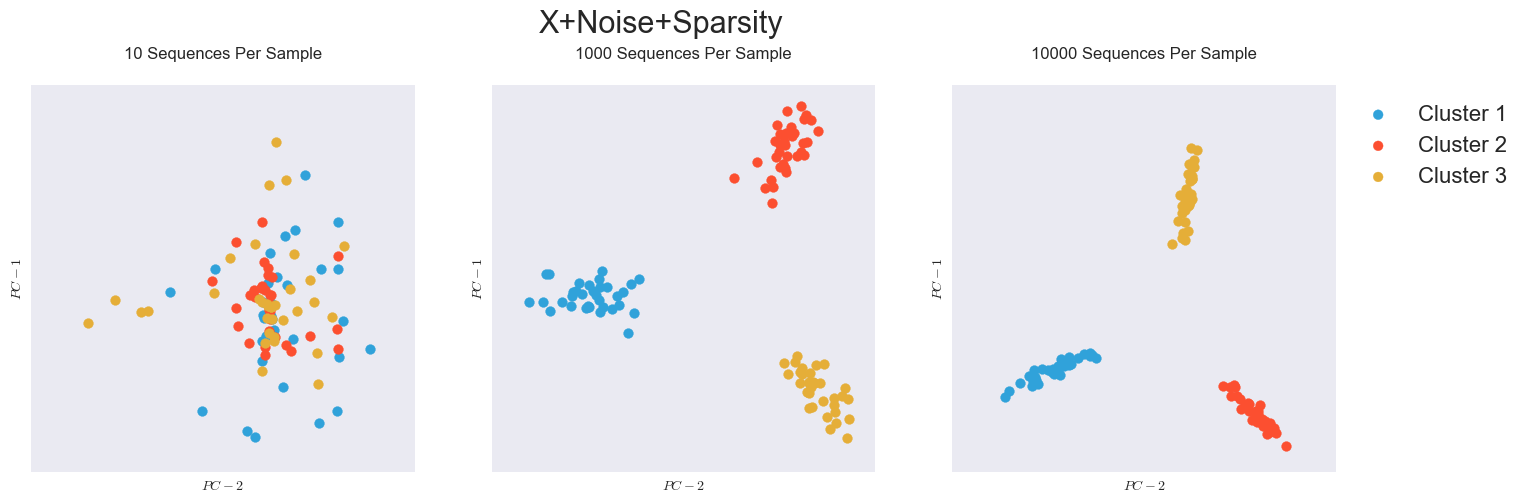

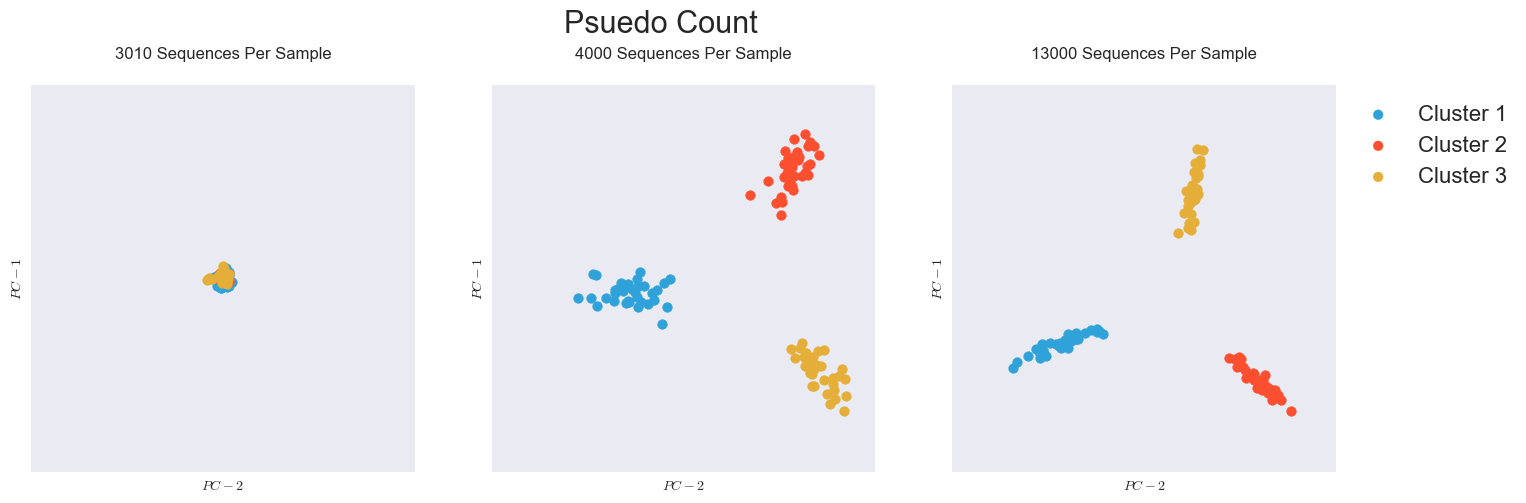

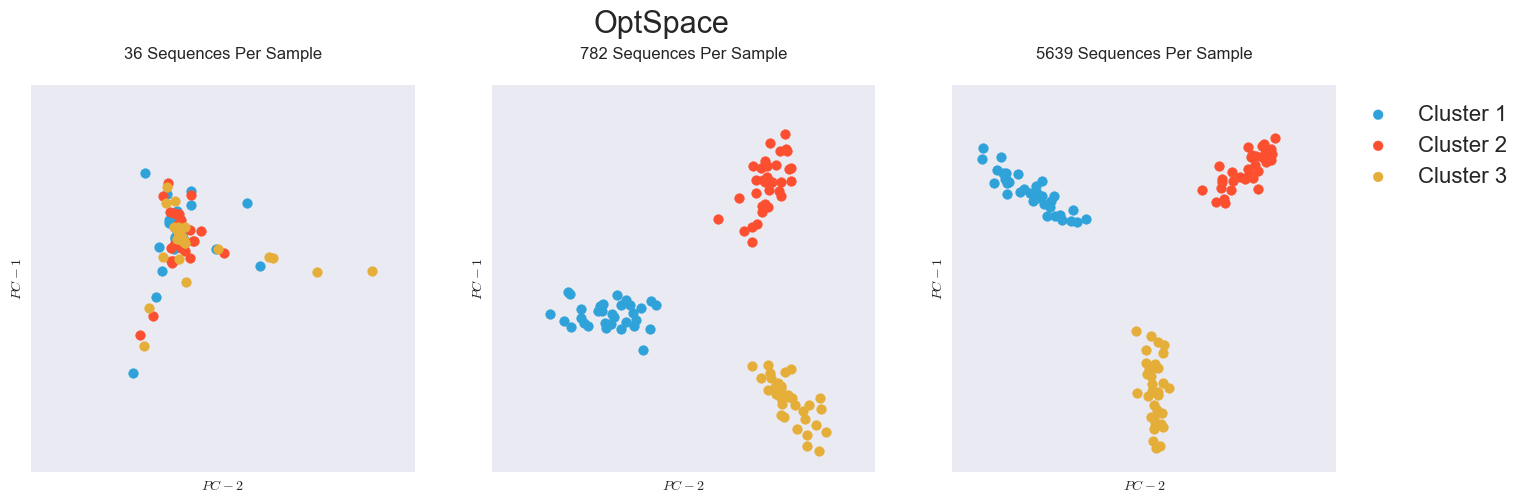

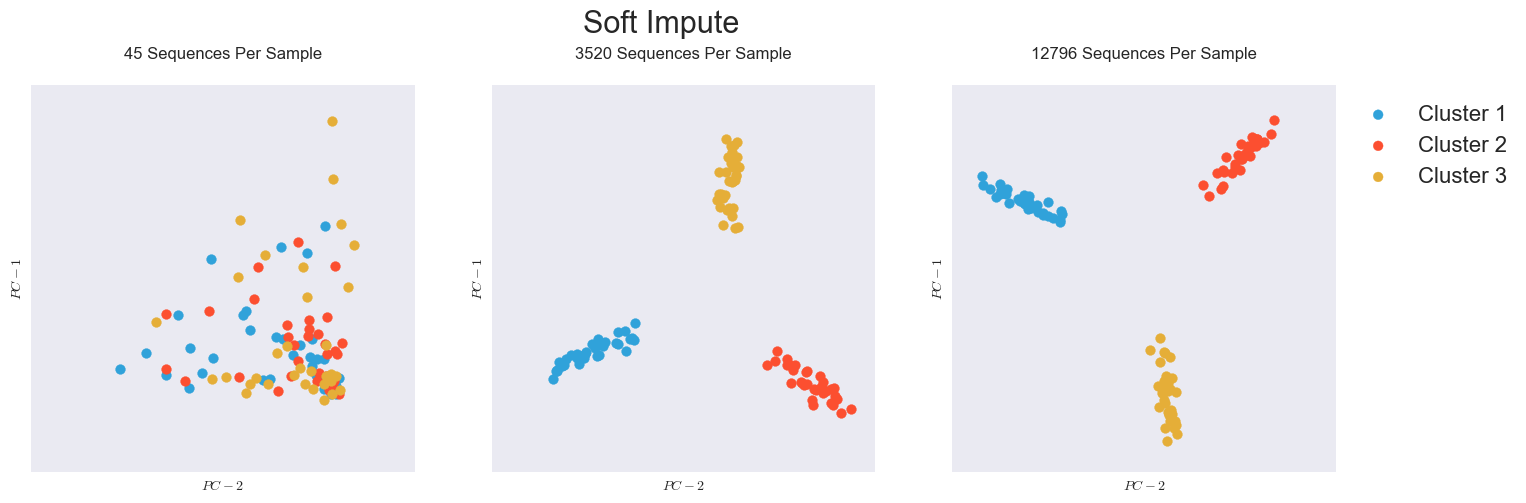

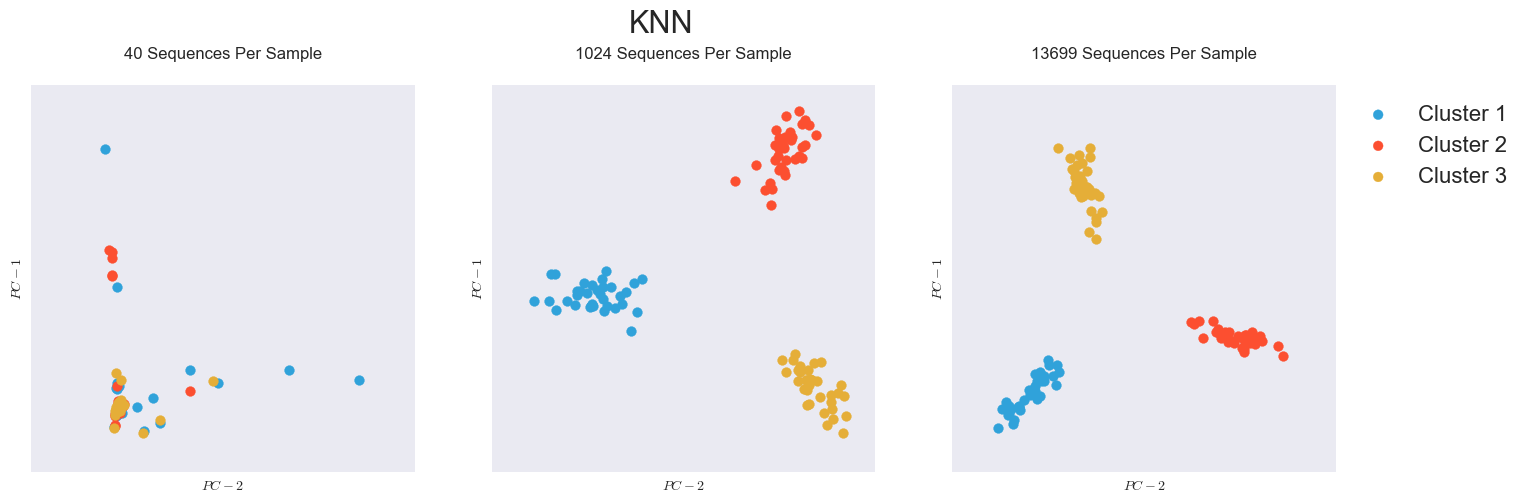

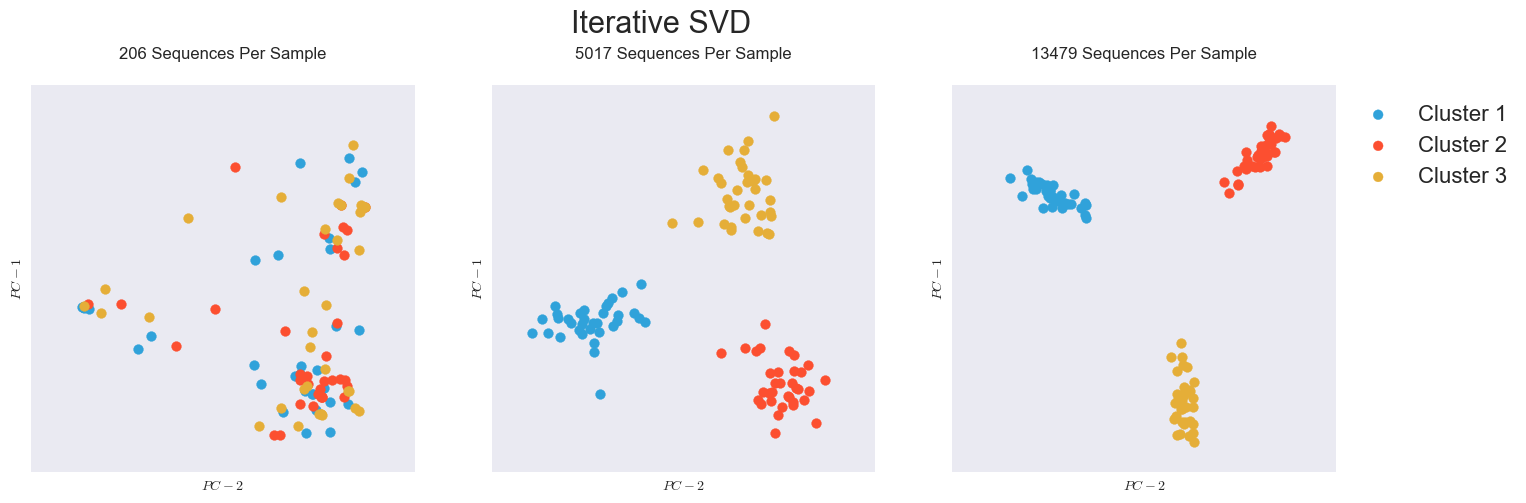

In [9]:
for X_recovered,suptit_ in zip([X_recovered_y,X_recovered_psuedo,X_recovered_opt,X_recovered_soft,X_recovered_knn,X_recovered_itersvd],
                       ['X+Noise+Sparsity','Psuedo Count','OptSpace','Soft Impute','KNN','Iterative SVD']):
    
    
    #plot recovered data
    fig=plot_pcoa(X_recovered,mapping.T,'example')
    plt.suptitle(suptit_,y=1.05,fontsize=22)
    plt.show()

# Now we can compare X to the different methods for producing a dense matrix (i.e. psuedo count vs. completion) through the mean Kullback–Leibler divergence for each method to X (our base truth) over many ranks with the same sample by row dimentions 

In [32]:
%%capture capt
mse=[]
method=[]
ranks=[]
num_seq=[]

for rank_ in list(range(2, 32, 2)):
    print('rank'+str(rank_))
    
    ### generate data ### 
    r=rank_ #numbers of blocks (rank of the matrix)
    n=102 # number of columns (Samples)
    b=1000 # number of rows (OTUS)
    # make a mock mapping data
    #mapping=pd.DataFrame(np.array([['Cluster %s'%str(x)]*int(n/r) for x in range(1,r+1)]).flatten(),columns=['example'],index=['sample_'+str(x) for x in range(0,n)])
    # make a mock OTU table
    X_true=pd.DataFrame(block_diagonal_gaus(n,b,r,minval=.01,maxval=30000),columns=['sample_'+str(x) for x in range(0,n)],index=['OTU_'+str(x) for x in range(0,(b))])
    #get noise to mimic real datasets 
    X_noise=add_noise(X_true,20,20,10,15)
    X_noise=X_noise.astype(int)
    
    
    subsample_points=[10,1000,5000]
    subsample_points=np.logspace(1,4,10)
    # sub sample 
    for sub_ in subsample_points:
        Subsamples_noisy=[]
        X_noise_sub=X_noise.copy()
        #sub samples
        for column in X_noise_sub.columns:
            X_noise_sub[column]=subsample_counts(X_noise_sub.astype(int)[column].values, sub_)

        Subsamples_noisy.append(X_noise_sub)
        
        #Complete
        X_recovered_psuedo=[]
        X_recovered_opt=[]
        X_recovered_soft=[]
        X_recovered_knn=[]
        X_recovered_itersvd=[]

        for X_noise_subsampled in Subsamples_noisy:

            #psuedo count
            X_recovered_psuedo.append(X_noise_subsampled+1)

            # OptSpace
            X_filled_opt=complete_matrix(X_noise_subsampled.as_matrix().copy(),rank=rank_+4,iteration=70,minval=1,maxval=1e1)  
            X_recovered_opt.append(pd.DataFrame(X_filled_opt,X_noise_subsampled.index,X_noise_subsampled.columns))

            # Make 0 NaN for fancy impute 
            X_noisefancy=X_noise_subsampled.copy()
            X_noisefancy[X_noisefancy==0]=np.nan

            # KNN
            X_filled_knn = KNN(k=20,verbose=False,min_value=1,max_value=1e1).complete(X_noisefancy)
            X_recovered_knn.append(pd.DataFrame(X_filled_knn,X_noise.index,X_noise.columns))

            #soft impute
            X_filled_softimpute = SoftImpute(verbose=False,min_value=1,max_value=1e1).complete(X_noisefancy)
            X_recovered_soft.append(pd.DataFrame(X_filled_softimpute,X_noise.index,X_noise.columns))

            # Iter SVD
            X_filled_iter=IterativeSVD(verbose=False,min_value=1,max_value=1e1).complete(X_noisefancy)
            X_recovered_itersvd.append(pd.DataFrame(X_filled_iter,X_noise.index,X_noise.columns))
            
        #MSE

        for count_,_ in enumerate(X_recovered_itersvd):
            
            kl_=mean_KL((X_true), (X_recovered_psuedo[count_]))
            mse+=kl_
            method+=['Psuedo Count']*len(kl_)
            ranks+=[rank_]*len(kl_)
            num_seq+=[sub_]*len(kl_)
            
            kl_=mean_KL((X_true), (X_recovered_opt[count_]))
            mse+=kl_
            method+=['OptSpace']*len(kl_)
            ranks+=[rank_]*len(kl_)
            num_seq+=[sub_]*len(kl_)
            
            kl_=mean_KL((X_true), (X_recovered_soft[count_]))
            mse+=kl_
            method+=['Soft Impute']*len(kl_)
            ranks+=[rank_]*len(kl_)
            num_seq+=[sub_]*len(kl_)
            
            kl_=mean_KL((X_true), (X_recovered_knn[count_]))
            mse+=kl_
            method+=['KNN']*len(kl_)
            ranks+=[rank_]*len(kl_)
            num_seq+=[sub_]*len(kl_)
            
            kl_=mean_KL((X_true), (X_recovered_itersvd[count_]))
            mse+=kl_
            method+=['KNN']*len(kl_)
            ranks+=[rank_]*len(kl_)
            num_seq+=[sub_]*len(kl_)

In [33]:
plot_all=pd.DataFrame([mse,method,ranks,num_seq],['Mean KL','Method','Number of Clusters','Sequences Per Sample']).T
plot_all=plot_all.apply(pd.to_numeric, errors='ignore')

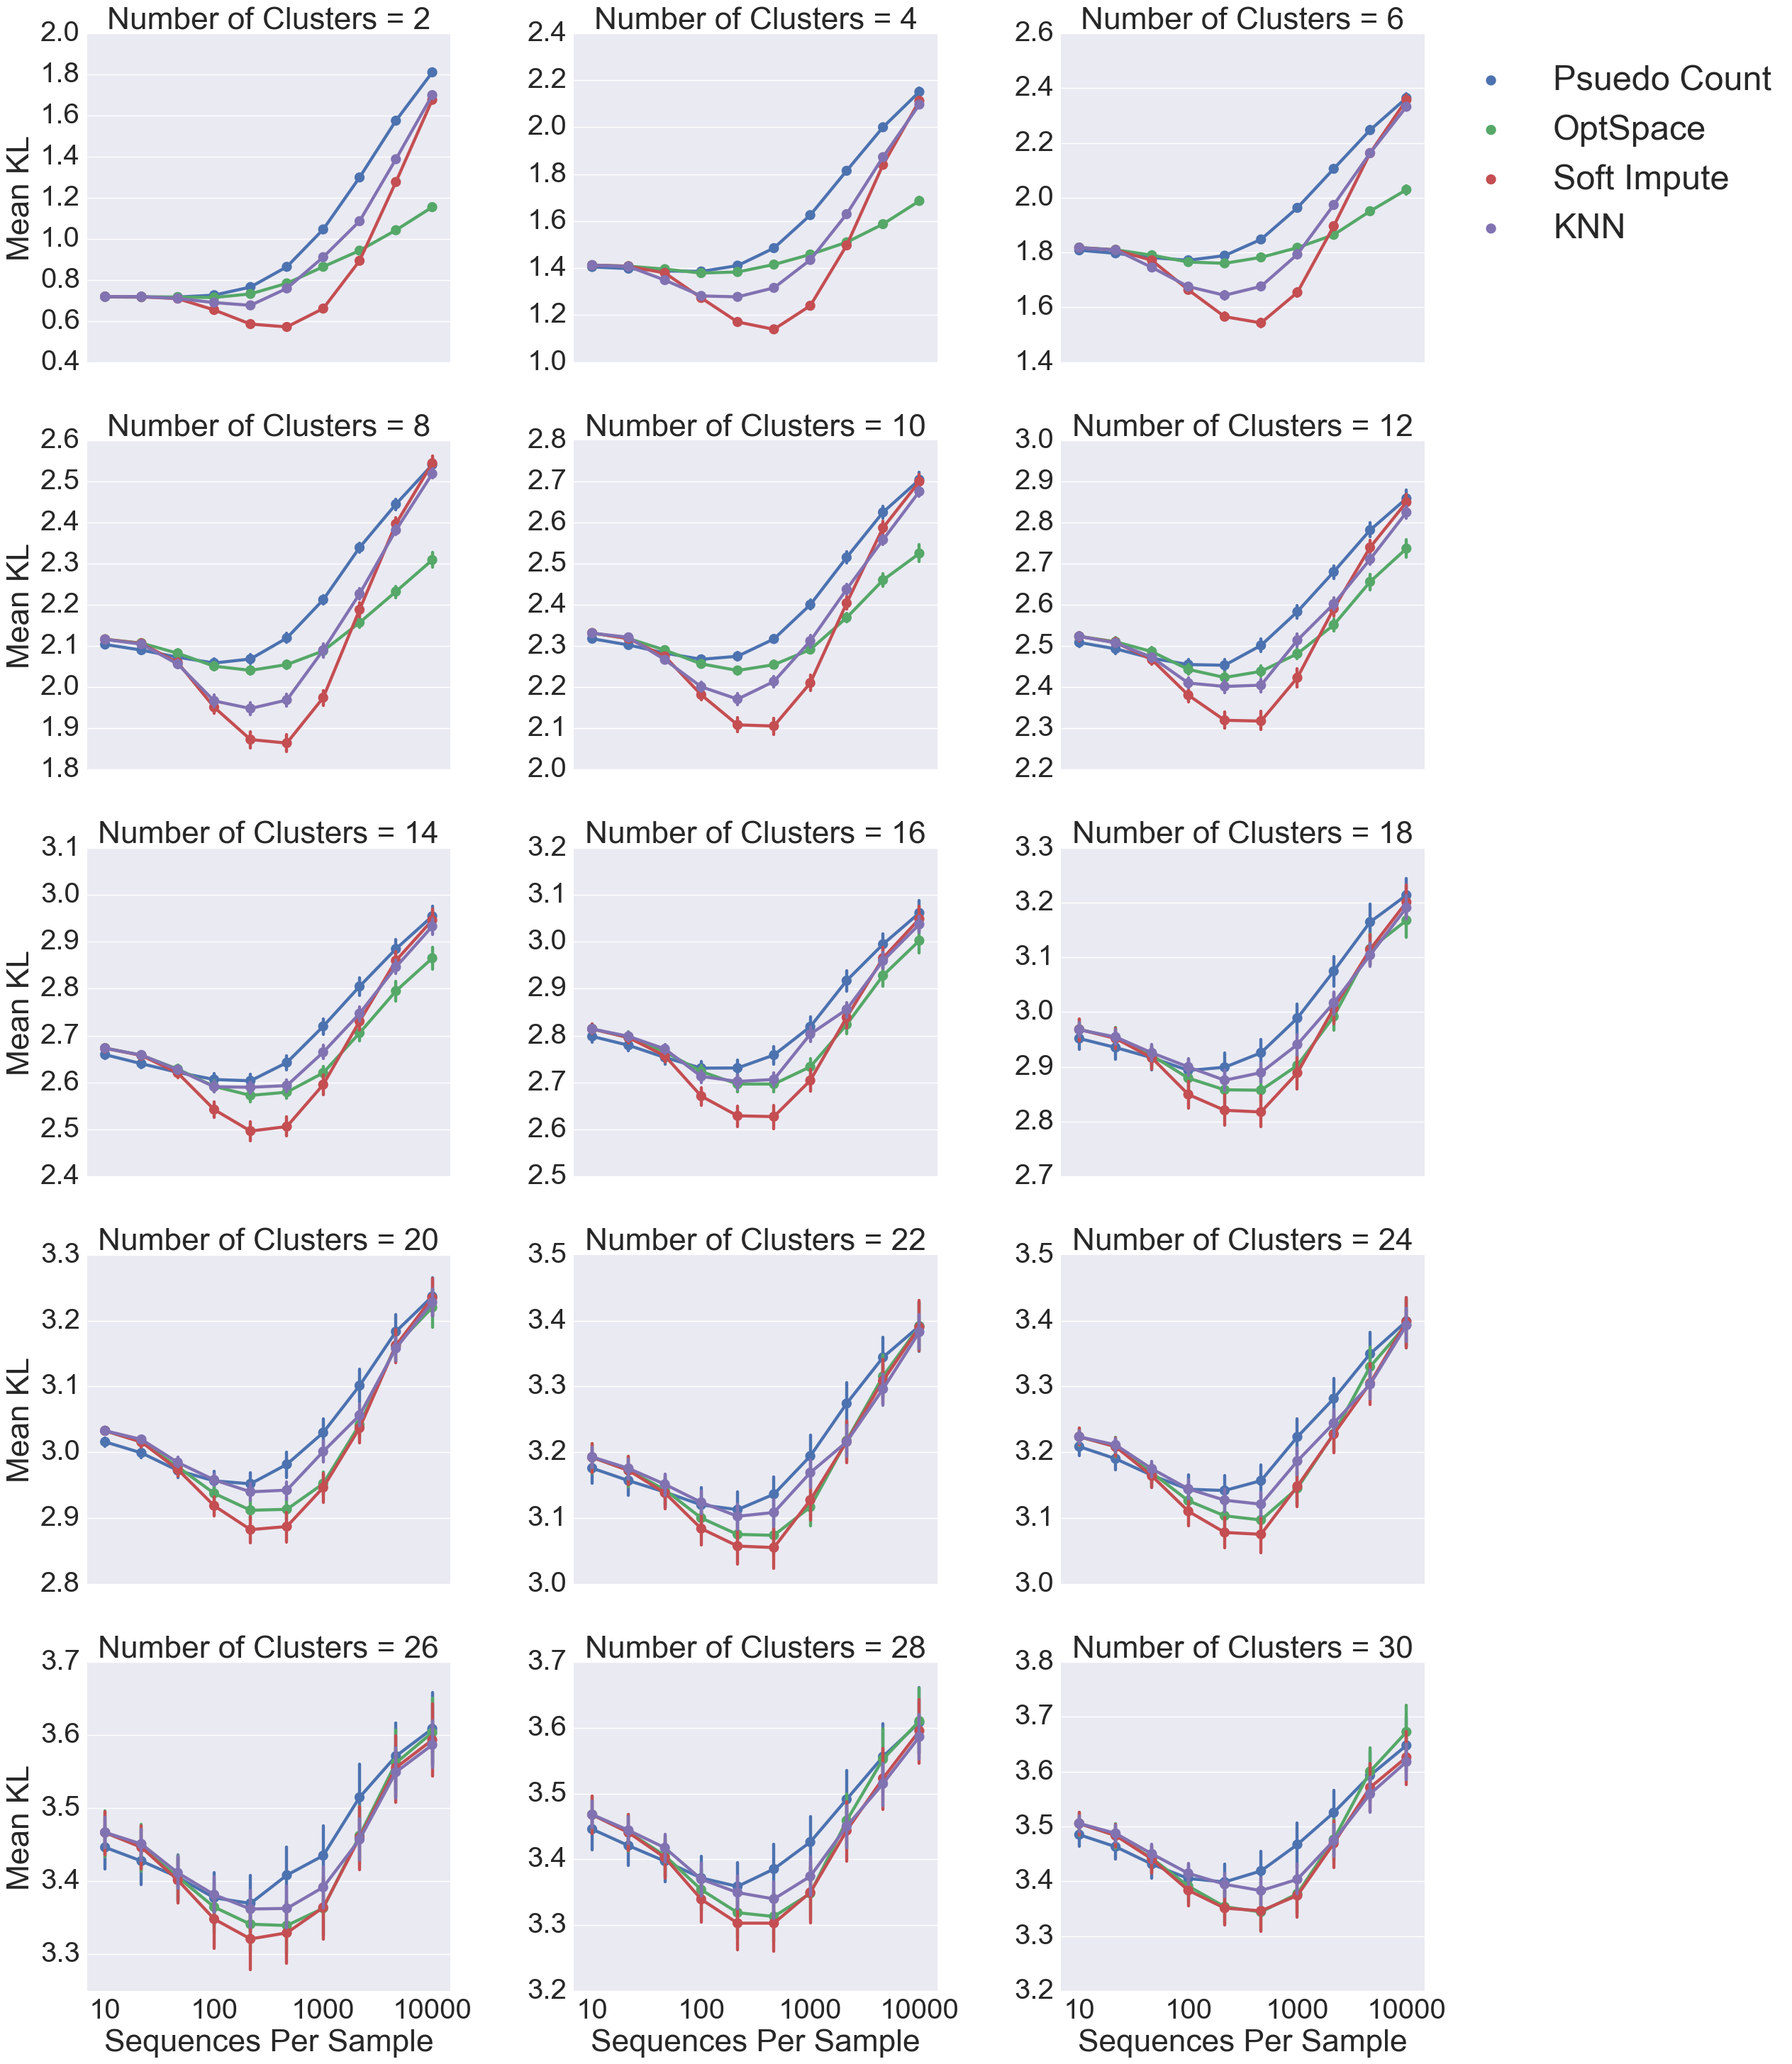

In [46]:
# Draw a pointplot to show pulse as a function of three categorical factors
sns.set(font_scale=2.9)

sns.factorplot(x="Sequences Per Sample", y="Mean KL", hue="Method", col="Number of Clusters", data=plot_all,
                   sharex=True, sharey=False,col_wrap=3, size=6, aspect=1.2,legend=False, kind="point")

plt.legend(bbox_to_anchor=(1.05, 5.9), loc=2, borderaxespad=0.,prop={'size':35})
loc, labels = plt.xticks()
labels=['%s'%str(x.get_text()).split('.')[0] for x in labels]
plt.xticks(loc[::3],labels[::3])

plt.show()